Example notebook to demonstrate how to make diagnostic plots using built in methods  

In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt

from gw_eccentricity import get_available_methods
from gw_eccentricity import measure_eccentricity
from gw_eccentricity.load_data import load_waveform
from gw_eccentricity.compare_methods import compute_errors_between_methods

%load_ext autoreload
%autoreload 2

/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


In [2]:
import glob
import matplotlib.pyplot as plt

In [52]:
q = 1
chi1 = 0
chi2 = 0
eob_waveforms_set1 = sorted(glob.glob(f"../data/ecc_waveforms/Non-Precessing/EOB/EccTest_q{q:.2f}_chi1z{chi1:.2f}_chi2z{chi2:.2f}_*_Momega00.010_meanAno1.571.h5"))

In [54]:
def compute_errors(method1, method2, waveform_path, zeroecc_waveform_path):
    waveform_keywords = {
        "filepath": waveform_path,
        "filepath_zero_ecc": zeroecc_waveform_path,
        "include_zero_ecc": True}
    dataDict = load_waveform(catalog="EOB", **waveform_keywords)
    tref_vec = dataDict["t"]
    tref_out1, ecc_vec1, mean_ano_vec1, gwecc_obj1 = measure_eccentricity(
        tref_in=tref_vec,
        dataDict=dataDict,
        method=method1, 
        return_gwecc_object=True,
        extra_kwargs={"debug": False})
    tref_out2, ecc_vec2, mean_ano_vec2, gwecc_obj2 = measure_eccentricity(
        tref_in=tref_vec,
        dataDict=dataDict,
        method=method2, 
        return_gwecc_object=True,
        extra_kwargs={"debug": False})
    t, ecc_errors, mean_ano_errors = compute_errors_between_methods(gwecc_obj1, gwecc_obj2)
    
    return t, ecc_errors, mean_ano_errors, gwecc_obj1, gwecc_obj2

In [70]:
zeroecc_path_set1 = f"../data/ecc_waveforms/Non-Precessing/EOB/EccTest_q{q:.2f}_chi1z{chi1:.2f}_chi2z{chi2:.2f}_EOBecc0.0000000000_Momega00.002_meanAno1.571.h5"
t, ecc_errs, mean_ano_errs, gwecc_obj1, gwecc_obj2 = compute_errors("ResidualAmplitude", "FrequencyFits", eob_waveforms_set1[140], zeroecc_path_set1)

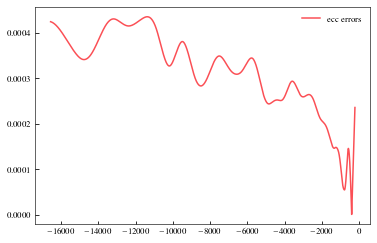

In [71]:
plt.plot(t, ecc_errs, label="ecc errors")
plt.legend()

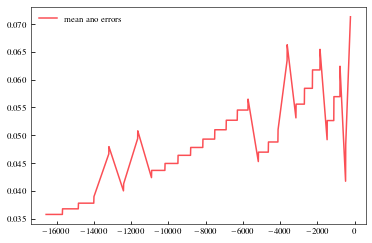

In [72]:
plt.plot(t, mean_ano_errs, label="mean ano errors")
plt.legend()

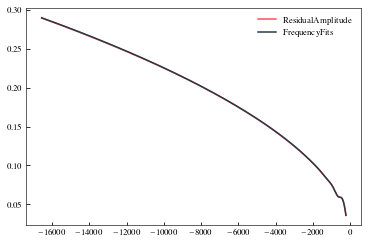

In [73]:
plt.plot(gwecc_obj1.tref_out, gwecc_obj1.ecc_ref, label=gwecc_obj1.method)
plt.plot(gwecc_obj2.tref_out, gwecc_obj2.ecc_ref, label=gwecc_obj2.method)
plt.legend()

### Loop over all eob waveforms in set 1 and compute the max error in eccentricity

In [74]:
import re
from tqdm import tqdm
import numpy as np

In [75]:
ecc_max_errs = []
t_max_errs = []
eccs = []
zeroecc_path_set1 = "../data/ecc_waveforms/Non-Precessing/EOB/EccTest_q1.00_chi1z0.00_chi2z0.00_EOBecc0.0000000000_Momega00.002_meanAno1.571.h5"
for waveform in tqdm(eob_waveforms_set1):
    # get the ecc from waveform path string
    ecc = re.search(".\d{10}", waveform)[0]
    eccs.append(float(ecc))
    t, ecc_errs, mean_ano_errs, gwecc_obj1, gwecc_obj2 = compute_errors("ResidualAmplitude", "FrequencyFits", waveform, zeroecc_path_set1)
    ecc_max_errs.append(max(np.abs(ecc_errs)))
    t_max_errs.append(t[np.abs(ecc_errs).argmax()])

  0%|                                                                                                                                                                                      | 0/150 [00:00<?, ?it/s]/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:450: UserWarning: Encountered negative eccentricity.
  warnings.warn("Encountered negative eccentricity.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:643: UserWarning: Number of pericenters and number of apocenters differ by 2. This implies that pericenters and apocenters are not appearing alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:596: UserWarning: Phase shift closer to pi than 2 pi detected.
  warnings.warn("Phase shift closer to pi than 2 pi detected.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:608: UserWarning: At least a pair of apocenters are too far. Maximum orbital phase d

### Make scatter plot of absolute errors

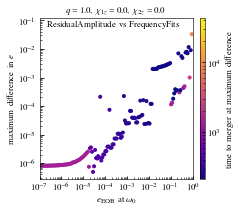

In [77]:
from gw_eccentricity.plot_settings import use_fancy_plotsettings, figWidthsOneColDict
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
cmap = cm.get_cmap("plasma")
journal = "APS"
use_fancy_plotsettings(journal=journal)
fig, ax = plt.subplots(figsize=(figWidthsOneColDict[journal], 3))
scatter = ax.scatter(eccs, ecc_max_errs, c=-np.array(t_max_errs),
                     cmap=cmap,
                     # s=15,
                     marker=".")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$e_\mathrm{EOB}$ at $\omega_0$")
ax.set_ylabel("maximum difference in $e$")
ax.set_title(fr"$q={q:.1f}$, $\chi_{{1z}}={chi1:.1f}$, $\chi_{{2z}}={chi2:.1f}$", ha="center")

# set major ticks
locmaj = mpl.ticker.LogLocator(base=10, numticks=20)
ax.xaxis.set_major_locator(locmaj)
# set minor ticks
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(0.1, 1.0, 0.1),
                               numticks=20)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.set_xlim(1e-7, 1.0)

# add colorbar
norm = mpl.colors.LogNorm(vmin=-np.array(t_max_errs).min(),
                          vmax=-np.array(t_max_errs).max())
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(r"time to merger at maximum difference")

# indicate methods
ax.text(0.05, 0.99, f"{gwecc_obj1.method} vs {gwecc_obj2.method}", ha="left", va="top",
       transform=ax.transAxes)
fig.tight_layout()
fig.savefig(f"max_ecc_erros_{gwecc_obj1.method}_{gwecc_obj2.method}.pdf")